<center><font size = "10"> Week 3 - Ion Channels <center>
<center><font size = "8">Home work<center>

<font size = "3">Please, write your group number and the names and surnames of the group members here
<br>Group number: 3
<br>Group member1: Laura TESTA
<br>Group member2: Alice ALBRECHT
<br>Group member3: Clara LE DRAOULEC
    
__IMPORTANT:__<font size = "3"> Exercises in <font color='red'>red</font> are mandatory assignements to be delivered by next Monday before 23:59.

# Optional. Conductance/voltage curve

<font size = "3">One way to describe ion channel kinetics is with a conductance/voltage curve. Using data stored in Sigmoid.dat file located in your group folder describing the conductance/voltage relationship for a particular ion channel, find its "best fit" curve using the sigmoid function outlined below:

<font size = "3">The sigmoid function :
\begin{equation}  
    y = \frac {1}{(1 + e^{(\frac{x - vh}{-slope})})}
\end{equation}
    
<font size = "3">Show the data and the fitted curve on the same plot (as it was done in tutorial 1), label the axes with correct units and create a legend to differentiate the data from the fitted curve. At what voltage does this channel reach half its maximal conductance value ? 

In [11]:
import pandas as pd
import numpy as np
import math
from scipy import stats
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import h5py
from neuron import h


In [12]:
def func_sigmoid(x, vh, slope):
    return 1/(1 + np.exp((x-vh)/-slope))

def curveFittingSingleSig(fileName):
    '''This function computes an exponential fitting for the data in fileName'''
    # Open the file and separate the columns in x and y
    df = pd.read_table(fileName, sep='\s+', header=None)
    x_data = df[0]
    y_data = df[1]
    
    # In this case, we want to compute vh = popt[0], slope = popt[1]
    # and to quantify the fitting quality we want to know perr
    popt, pcov = curve_fit(func_sigmoid, x_data, y_data)
    perr = np.sqrt(np.diag(pcov))
    
    plt.figure(figsize=(10,6))
    plt.plot(x_data, y_data, 'xk', label='original data' )
    plt.plot(x_data, func_sigmoid(x_data, popt[0], popt[1]), '-r',label='fit: vh=%.3f (err=%.3f), slope=%.3f (err=%.3f)' %(popt[0], perr[0], popt[1], perr[1]))
    plt.legend()
    plt.xlabel('Voltage (V)')
    plt.ylabel('Conductance (G)')
    plt.title('Conductance/Voltage curve')
    plt.axvline(x=-19.735, c='k', ls='--', lw=1)
    plt.axhline(y=0.5, c='k', ls='--', lw=1)
    plt.show()

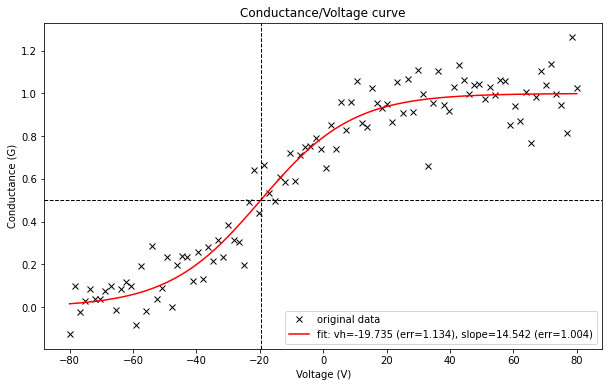

In [13]:
data_path = 'data/Sigmoid.dat'
curveFittingSingleSig(data_path)

This channel reaches it maximal conductance at a voltage of -19,735 mV with an error of 1,134. 

# <font color= 'red'>Ex1:</font> Analysing an activation curve.

<font size = "3">Plot each of the traces from the .NWB file in your folder group on one plot and inspect the traces.  Fit each of the traces between a timepoint of your choice (the same for all traces) and the maximum amplitude of the trace to an exponential, to find the time constant at every voltage step. What does this time constant represent ? Plot the time constants for the activation, considering that the clamped voltage stimulation is between -90 and +80 mV with a 10mV step interval. <font color= 'red'>[2 pts]


In [14]:
data_path = 'data/rCell7518.nwb'
protocolName = 'Activation'
repID = '1'

def func_exp(x, a, b, tau):
    return a + b*(1-np.exp(-x/tau))

In [70]:
# plot the traces from nwb file and get the traces and corresponding time vectors
def plotDataFiles(nwbFile, protocolName, repID, plotTraces=False):
    ''' Function .....
    :param nwbFile: the data path to file
    :param protocolName: protocol name defined in the data file
    :param repID: protocol repetition number
    :param byTraces: if true, represent each trace in one figure'''
    
    # Open the file
    open_data = h5py.File(nwbFile, 'r')
    
    # Select on strings what do we want for ploting
    string_data = '/acquisition/timeseries/'+ protocolName + '/repetitions/repetition' + repID +'/data'
    string_xinterval = '/acquisition/timeseries/'+ protocolName + '/repetitions/repetition' + repID +'/x_interval'
    string_xstart = '/acquisition/timeseries/'+ protocolName + '/repetitions/repetition' + repID +'/x_start'
    
    # safe on different variables
    data = open_data[(string_data)]
    x_interval = open_data[(string_xinterval)]
    x_start = open_data[(string_xstart)]
    
    # create time vector in ms
    nRow, nCol = data.shape
    x_end = x_start[0] + x_interval[0]*(float(nRow - 1))
    time = np.linspace(x_start[0], x_end, nRow)*1000
    
    if plotTraces==False:
    
        # way 1: all the traces in one figure
        plt.figure()
        plt.title('%s protocol' %protocolName)
        plt.ylabel('voltage traces (mV)')
        plt.xlabel('time (ms)')
        plt.plot(time, data, 'b')
        plt.show()
        
        
    if plotTraces==True:
        data_t = np.transpose(data)
        fixed_t = 5800
        i = 0
        tau_values = []

        for trace in data_t:
            plt.figure()
            
            plt.plot(time, trace, 'b')
            

            # Find the max 
            max_trace = list(trace).index(max(trace))       

            # Plot the exponential curve
            x_data = time[min(max_trace,fixed_t):max(max_trace,fixed_t),0]
            y_data = trace[min(max_trace,fixed_t):max(max_trace,fixed_t)]
            popt, pcov = curve_fit(func_exp, x_data, y_data, p0=[1, 100, 100])
            tau_values.append(popt[2])
            perr = np.sqrt(np.diag(pcov))
            plt.plot(x_data,y_data,'k')
            plt.plot(x_data, func_exp(x_data, popt[0], popt[1], popt[2]))
            plt.title('%s protocol, fitted trace %s, tau=%f' %(protocolName,i, popt[2]))
            plt.ylabel('voltage traces (mV)')
            plt.xlabel('time (ms)')
            print
            i = i + 1
            
            plt.show() 
            
        voltage_range = np.arange(start=-90, stop=90, step=10)
        plt.plot(voltage_range, tau_values)
        plt.title('Tau values according to voltage')
        plt.xlabel('Voltages [mV]')
        plt.ylabel('Tau values [ms]')
        plt.xlim(-95,80)
        plt.grid(True)
    


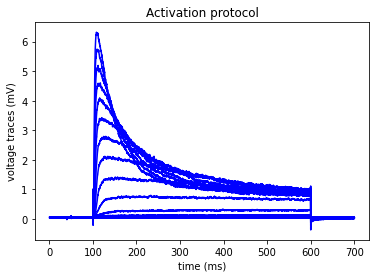

In [71]:
# Call the previous function and plot the Activation curves
plotDataFiles(data_path, 'Activation', '1', plotTraces=False)

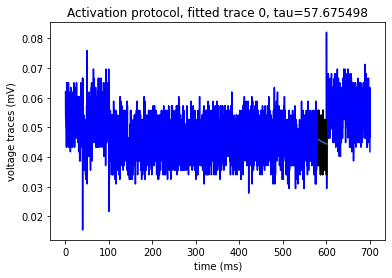

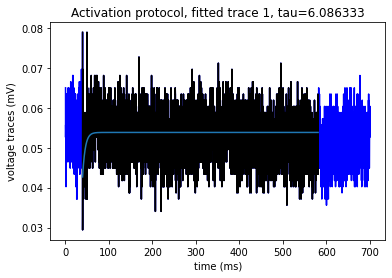

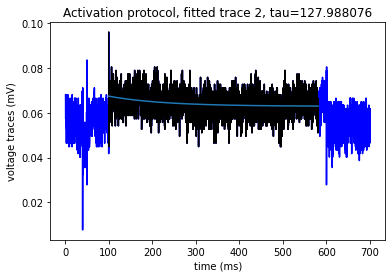

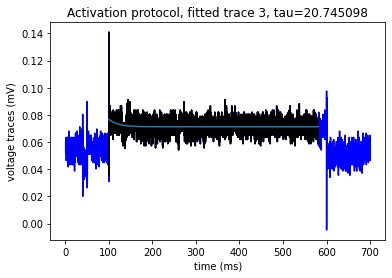

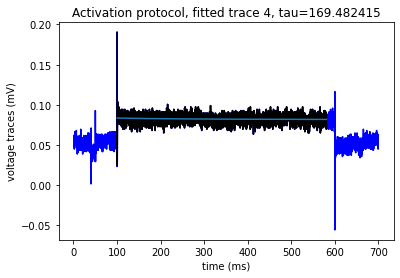

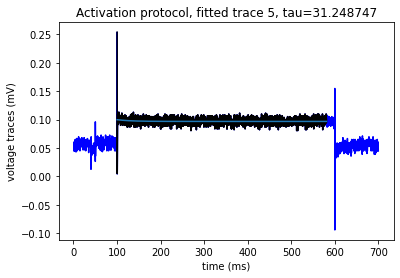

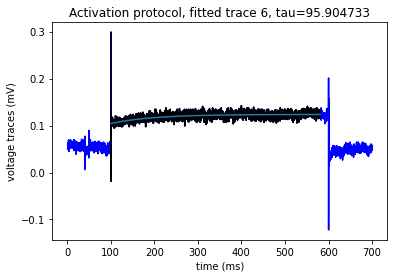

/usr/local/lib/python3.8/dist-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


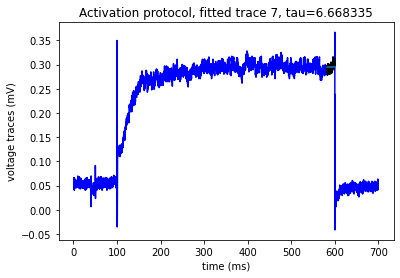

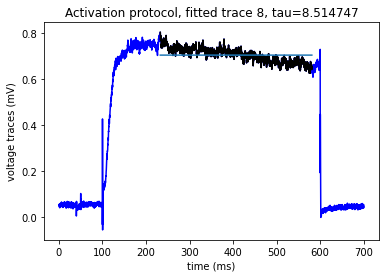

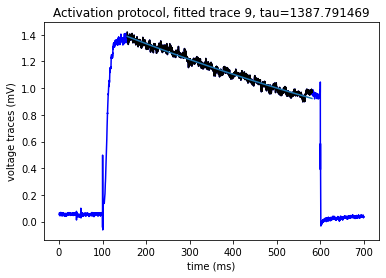

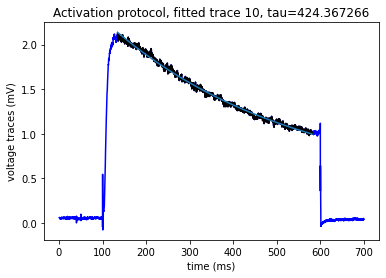

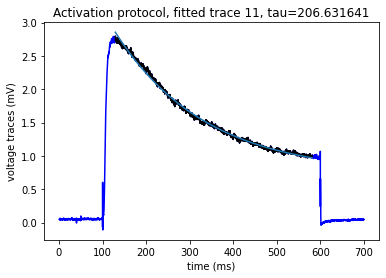

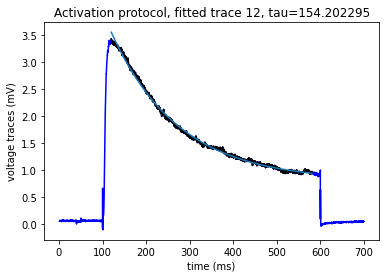

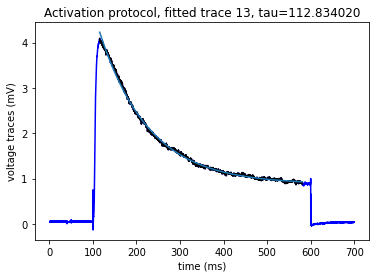

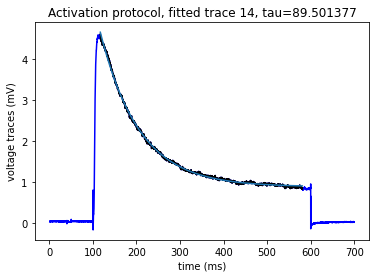

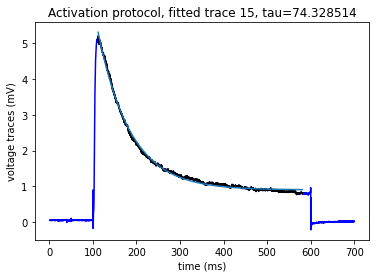

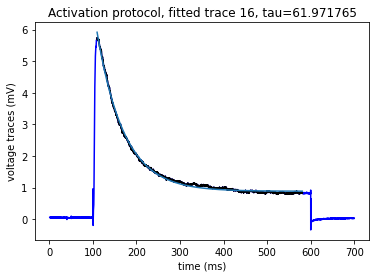

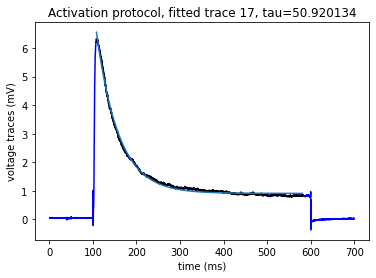

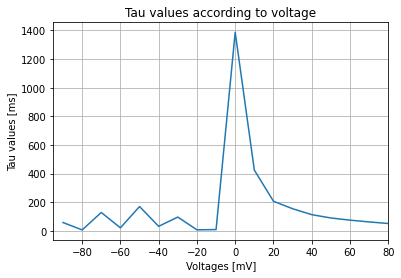

In [72]:
plotDataFiles(data_path, 'Activation', '1', plotTraces=True)

One trace could not be accurately estimated since the trace follow an exponential with a positive curve. Therefore, we should not consider it, as it is not the general behvior of the trace.

The time constant, also called tau, represents the time constant of the membrane, which represents the time to achieve a 63% of change in the membrane voltage. Tau dpeends on the capacitive properties of the membrane: Tau = Rm\*Cm, where Cm is the capacitance and R the resistance of the membrane. 

# <font color= 'red'>Ex2:</font> Finding the rheobase of a cell

<font size = "3">Create a cell in Neuron with the fillowing characteristics: 1 section (soma) with one segment, 15 µm of length and diameter, 120 Ω*cm of axial radius and 1.6 µF/cm^2 of capacitance. Add passive and active (gNa = 0.09 S and gK = 0.01 S) membrane properties to this cell. Generate a current clamp experiment in which you inject 0.028 pA current into the cell soma with 50 ms delay, 500ms in duration. Use a voltage base of -70 mV and set the total recording duration of the experiment to 800ms. This is your base experiment - plot the injeted currnet and the voltage reponse. Now try to modify the injected current to find the rheobase of this cell - what is its amplitude ? What is the threshold membrane voltage for this cell? 
Now generate a second current clamp experiment where you first inject rheobase current strength into the cell soma with 50 ms delay for 60 ms in duration (stimulus 1) and then a second stimulus with 180 ms delay, half the duration and double the amplitude of simulus 1. What do you observe ? What can you conclude ? Plot the injected current and the voltage response, justify your answer. <font color= 'red'>[1.5 pt]

1. First we create a cell with passive and active membrane properties and inject a current to get the base experiment.

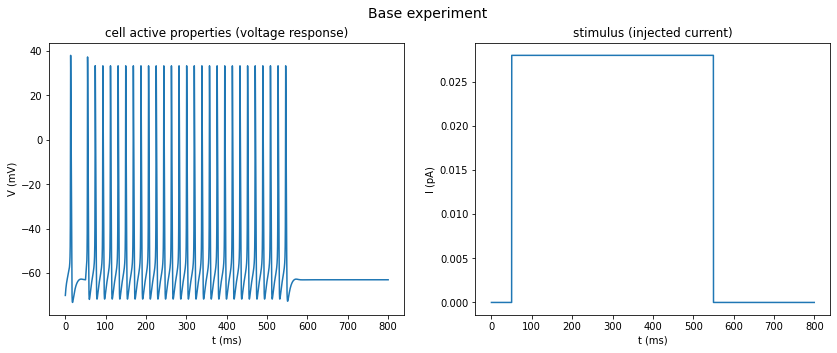

In [10]:
# Create a section 
soma = h.Section()
soma.nseg = 1     # number of segment
soma.L = 15.0     # length (µm)
soma.diam = 15.0  # diameter (µm)
soma.Ra = 120.0   # axial resistivity (Ω*cm)
soma.cm = 1.6     # capacitance (µF/cm^2) 

# Insert passive properties (AUCUNE INFO DANS L'ENONCE MAIS C'EST TOUJOURS CES VALEURS DANS LES TUTOS)
soma.insert('pas')
for seg in soma:
    seg.pas.g = 0.0003 # conductance of the leak channels (in S/cm2)
    seg.pas.e = -70    # leak reversal potential, it influences the steady state membrane potential

# Insert hh
soma.insert('hh')
for seg in soma:
    seg.hh.gkbar = 0.01   # Maximal conductance of the potassium channels
    seg.hh.gnabar = 0.09  # Maximal conductance of the sodium channels
    
# Inject a current step into the soma
stim = h.IClamp(soma(0.5)) # place a stimulation electrode in the middle of the soma
stim.amp = 0.028           # stim amplitude (pA)
stim.delay = 50            # stim delay (ms)
stim.dur = 500             # stim duration (ms)

# Initialize NEURON vectors to record time, voltage and current
# time vector
rec_t = h.Vector()
rec_t.record(h._ref_t)
# membrame potential vector
rec_v = h.Vector()
rec_v.record(soma(0.5)._ref_v)
# current
rec_i = h.Vector()
rec_i.record(stim._ref_i)

# Initialize and run a simulation
h.load_file('stdrun.hoc')
h.finitialize(-70)     # initial voltage 
h.continuerun(800);    # total recording duration

# Plot of the base experiment
plt.figure(figsize=(14,5))
plt.suptitle('Base experiment', fontsize = 14);

plt.subplot(121)
plt.title('cell active properties (voltage response)')
plt.ylabel('V (mV)')
plt.xlabel('t (ms)')
plt.plot(rec_t,rec_v)

plt.subplot(122)
plt.title('stimulus (injected current)')
plt.ylabel('I (pA)')
plt.xlabel('t (ms)')
plt.plot(rec_t,rec_i);

2. Now, we test different current amplitude in order to determine the rheobase, which correpsond to the minimal current amplitude of infinite duration that results in the depolarization threshold of the cell membranes being reached, such as an action potential or the contraction of a muscle.

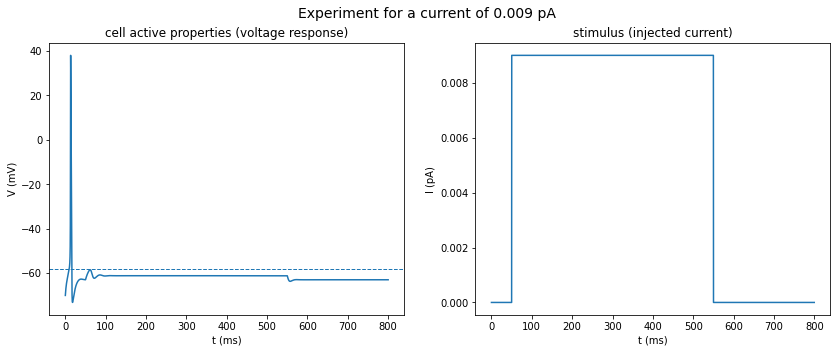

In [11]:
# Change the current amplitude to 0.009 to see that it DOESN'T fire AP
stim.amp = 0.009       # stim amplitude (pA)
h.finitialize(-70)     # initial voltage 
h.continuerun(800);    # total recording duration

# Plot the injected current and voltage response
plt.figure(figsize=(14,5))
plt.suptitle('Experiment for a current of 0.009 pA', fontsize = 14);

plt.subplot(121)
plt.title('cell active properties (voltage response)')
plt.ylabel('V (mV)')
plt.xlabel('t (ms)')
plt.plot(rec_t,rec_v)
plt.axhline(y = -58, ls='--', lw=1)

plt.subplot(122)
plt.title('stimulus (injected current)')
plt.ylabel('I (pA)')
plt.xlabel('t (ms)')
plt.plot(rec_t,rec_i);

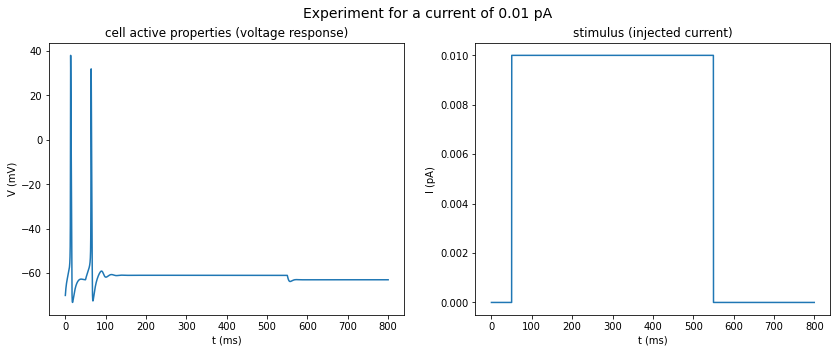

In [12]:
# Change the current amplitude to 0.01 to see that it DOES fire AP
stim.amp = 0.01        # stim amplitude (pA)
h.finitialize(-70)     # initial voltage 
h.continuerun(800);    # total recording duration

# Plot the injected current and voltage response
plt.figure(figsize=(14,5))
plt.suptitle('Experiment for a current of 0.01 pA', fontsize = 14);

plt.subplot(121)
plt.title('cell active properties (voltage response)')
plt.ylabel('V (mV)')
plt.xlabel('t (ms)')
plt.plot(rec_t,rec_v)

plt.subplot(122)
plt.title('stimulus (injected current)')
plt.ylabel('I (pA)')
plt.xlabel('t (ms)')
plt.plot(rec_t,rec_i);

By modifying the value of the current amplitude we can see that an AP is NOT fire for a current of 0.009 but there is an AP for a current of 0.01. We deduce a rheobase of 0.01 pA for the futher steps of this exercice. The coltage threshold is around -58mV deduce thanks to the voltage response plot for a current amplitude of 0.009 pA.

3. We take the rheobase value as current amplitude and create a new experiment with not one but two stimuli with different delay and duration.

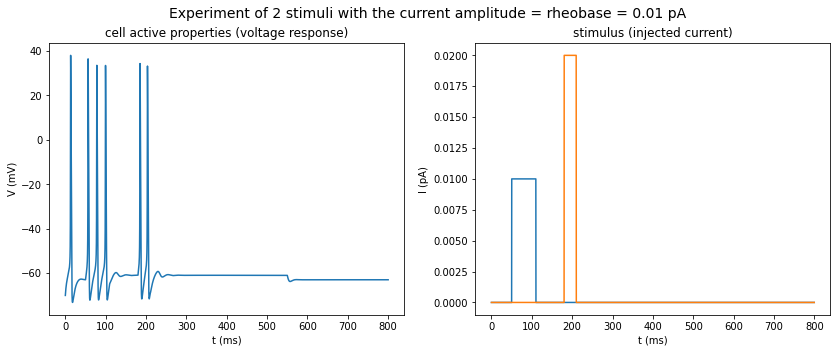

In [14]:
# Inject 2 current steps into the soma
stim1 = h.IClamp(soma(0.5)) # place a stimulation electrode in the middle of the soma
stim1.amp = 0.01        # stim amplitude (pA) corresponding to rheobase
stim1.delay = 50        # stim delay (ms)
stim1.dur = 60          # stim duration (ms)

stim2 = h.IClamp(soma(0.5)) # place a stimulation electrode in the middle of the soma
stim2.amp = 0.02        # stim amplitude (pA) corresponding to rheobase
stim2.delay = 180       # stim delay (ms)
stim2.dur = 30          # stim duration (ms)


# Initialize NEURON vectors to record time, voltage and current
# time vector
rec_t = h.Vector()
rec_t.record(h._ref_t)
# membrame potential vector
rec_v = h.Vector()
rec_v.record(soma(0.5)._ref_v)
# current
rec_i1 = h.Vector()
rec_i1.record(stim1._ref_i)   # first stimuli
# current
rec_i2 = h.Vector()
rec_i2.record(stim2._ref_i)   # second stimuli

# Initialize and run a simulation
h.finitialize(-70)     # initial voltage 
h.continuerun(800);    # total recording duration

# Plot the injected current and voltage response
plt.figure(figsize=(14,5))
plt.suptitle('Experiment of 2 stimuli with the current amplitude = rheobase = 0.01 pA', fontsize = 14);

plt.subplot(121)
plt.title('cell active properties (voltage response)')
plt.ylabel('V (mV)')
plt.xlabel('t (ms)')
plt.plot(rec_t,rec_v);

plt.subplot(122)
plt.title('stimulus (injected current)')
plt.ylabel('I (pA)')
plt.xlabel('t (ms)')
plt.plot(rec_t,rec_i1)
plt.plot(rec_t,rec_i2);

# <font color= 'red'>Ex3:</font> Modifing K+ channel kinetics

<font size = "3">Considering the Boltzmann sigmoid function used to represent ion channel dynamics (slide 31 from this week's lecture), explain the meaning of the parameter V1/2. Considering only the dynamics for Na+ and K+ channels in a neuron, illustrate what is the effect of increasing and decreasing the value of V1/2 for the K+ channel. 
To do so, create a cell in Neuron with the following characteristics: 1 section (soma) with one segment, 17.0 µm of length and diameter, 122 Ω*cm of axial radious and 1.2 µF/cm^2 of capacitance. Add passive and active (gNa = 0.09 S and gK = 0.01 S) membrane properties to this cell. Generate a current clamp experiment in which you inject a current into the cell soma with 150 ms delay, 600 ms of duration. The total recording duration of the experiment should be 1000 ms and the voltage base -70 mV. 

<font size = "3">Increase and decrase the v_half parameter on the mod file with the K+ channel kinetics. Plot the resulting voltage curves and the I-V and tau-V curves. 
<font size = "3">Explain the meaning of v_half and what you observe. Why does changing this parameter affect the resultant action potential? <font color= 'red'>[2.5 pts]


#### Boltzmann sigmoid function

In the Boltzmann sigmoid function, the V1/2 reprensents the voltage at which half the maximum conductance is reached. 

In [ ]:
# This will compile the mechanisms inside the MOD files (and create a new folder x86_64/special).
! nrnivmodl

In [ ]:
# Create a section
soma = h.Section()
soma.nseg = 1     # number of segment
soma.L = 17.0     # length (µm)
soma.diam = 17.0  # diameter (µm)
soma.Ra = 122.0   # axial resistivity (Ω*cm)
soma.cm = 1.2    # capacitance (µF/cm^2) 

# Insert passive properties
soma.insert('pas')
for seg in soma:
    seg.pas.g = 0.0003 # Conductance of the leak channels (in S/cm2)
    seg.pas.e = -70   # Leak reversal potential, it influences the steady state membrane potential

# INSERT MODELS
soma.insert('K_Ch_mInf') ######## This channel dynamic desciption is in K_channel_change_mInf.mod
for seg in soma:
    seg.gKv3bar_K_Ch_mInf = 0.01   # Maximal conductance of the potassium channels

soma.insert('Na_Ch')
for seg in soma:
    seg.gNa_Sbar_Na_Ch = 0.09   # Maximal conductance of the sodium channels
    
    
# Inject a current step into the soma
stim = h.IClamp(soma(0.5)) # place a stimulation electrode in the middle of the soma
stim.amp = 0.028           # don't know which amplitude
stim.delay = 150            # stim delay (ms)
stim.dur = 600             # stim duration (ms)


# Initialize NEURON vectors to record time, voltage and current
# time vector
rec_t = h.Vector()
rec_t.record(h._ref_t)
# membrame potential vector
rec_v = h.Vector()
rec_v.record(soma(0.5)._ref_v)


# K current
rec_iK = h.Vector()
rec_iK.record(soma(0.5)._ref_ik)

# Initialize and run a simulation
h.load_file('stdrun.hoc')
h.finitialize(-70)     # initial voltage 
h.continuerun(1000);    # total recording duration

# PLOT
plt.figure(figsize=(20,3))
plt.subplot(131)
plt.title('cell with Na and K channel models')
plt.ylabel('V (mV)')
plt.xlabel('t (ms)')
plt.plot(rec_t,rec_v, 'b')

plt.subplot(132)
plt.title('current thourgh K channel')
plt.ylabel('I (pA)')
plt.xlabel('t (ms)')
plt.plot(rec_t,rec_iK, 'g')


In [ ]:
# v_half = 18.7 mV
I1 = np.arange(0.00001, 1.0, 0.001)
V1 = []
for i1 in I1:
    v1 = 18.7 - 9.7*math.log((1/i1)-1)
    V1.append(v1)

# v_half = 28.7 mV
I2 = np.arange(0.000001, 1.0, 0.001)
V2 = []
for i2 in I2:
    v2 = 28.7 - 9.7*math.log((1/i2)-1)
    V2.append(v2)

plt.figure()
plt.xlabel('voltage (mV)')
plt.ylabel('current (pA)')
plt.plot(V1, I1, 'g', label='v1/2 = 18.7 mV')
plt.plot(V2, I2, 'k',label='v1/2 = 28.7 mV')
plt.legend()

In [ ]:
Volt = np.arange(0, 50, 2)
I = np.arange(0.00001, 1.0, 0.001)

for idx, v in enumerate(Volt) :
    
    V2 = []
    for i in I :
        v1 = v - 9.7*math.log((1/i)-1)
        V2.append(v1)
         
    plt.figure()
    plt.xlabel('voltage (mV)')
    plt.ylabel('current (pA)')
    plt.plot(V2, I, 'g', label='v1/2 =%.3f)' %(v))
    plt.legend()